# Sneaker Authenticity Detection: Training Walkthrough

## Overview
This notebook implements a **multimodal Vision Transformer (ViT)** model that combines image analysis, brand recognition, and price information to detect counterfeit sneakers.

## Quick Summary

### Training Approach
1. **Transfer Learning**: Uses pretrained ViT-Base (ImageNet), **fine-tuned** (not frozen) on sneaker images
2. **Brand Recognition**: Model learns to identify brands from images (auxiliary task) while using brand context
3. **Price Learning**: Learns price-brand-authenticity patterns from training data
4. **Multi-Task Learning**: Trains on authenticity + brand classification + contrastive learning simultaneously

### Model Architecture
- **Image Path**: ViT-Base → 768-dim → Projection → 512-dim image embedding
- **Brand Path**: Brand Embedding (64-dim) + Brand Classification Head (learns brand from images)
- **Price Path**: Log-transform → Standardize → Projection → 64-dim price embedding
- **Fusion**: Concatenate [512 + 64 + 64] → Authenticity Head → Binary prediction

### Decision Making
The model combines all three factors (image, brand, price) simultaneously:
- **Image features** (512-dim): Visual patterns, logo quality, materials, craftsmanship
- **Brand context** (64-dim): Brand-specific authenticity patterns
- **Price validation** (64-dim): Learned price patterns for each brand

**For detailed explanation, see: `TRAINING_WALKTHROUGH.md`**



In [ ]:
# Cell 0 - Setup (Colab)
# Run in Google Colab: mounts drive, installs timm
from google.colab import drive
drive.mount('/content/drive')

# Install packages if needed
!pip install -q timm scikit-learn pandas tqdm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cell 1 - imports & config
import os, glob, random, time
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image

# Suppress PIL warnings about palette images with transparency
warnings.filterwarnings('ignore', category=UserWarning, message='.*Palette images with Transparency.*')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import timm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from tqdm.auto import tqdm

# ===== IMPROVED CONFIG FOR SMALL DATASET (258 images) =====
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
project_dir = "/content/drive/.shortcut-targets-by-id/1_W0siwvNP6g1PwXWIayo1bsrPYp0ui5S/Counterfeit-Product-Image-Detection"
train_image_root = f"{project_dir}/data/sneakers"
test_image_root = f"{project_dir}/data/test"

# OPTIMIZED for test accuracy - reduce false positives (authentic marked as fake)
BATCH_SIZE = 16
IMG_SIZE = 224
NUM_EPOCHS = 20
LR = 2e-4  # Increased to learn faster
WEIGHT_DECAY = 1e-4  # Further reduced - minimal regularization
BACKBONE = 'vit_base_patch16_224'
FREEZE_BACKBONE = False
FREEZE_LAYERS = 2  # Reduced from 3 - train more layers
BRAND_EMBED_DIM = 64
OUT_DIM = 512
USE_CONTRASTIVE = True
CONTRASTIVE_TEMPERATURE = 0.1
AUX_BRAND_LOSS = True
BRAND_LOSS_WEIGHT = 0.3  # Reduced back - don't over-emphasize brand
CONTRASTIVE_LOSS_WEIGHT = 0.03  # Further reduced
USE_FOCAL_LOSS = False
FOCAL_ALPHA = 0.25
FOCAL_GAMMA = 2.0
LABEL_SMOOTHING = 0.0  # DISABLED - no label smoothing
USE_MIXUP = False
MIXUP_ALPHA = 0.2
USE_EARLY_STOPPING = True
EARLY_STOP_PATIENCE = 7
PREDICTION_THRESHOLD = 0.4  # Lower threshold - reduce false positives (was 0.5)
SAVE_PATH = "/content/best_model.pth"

print("Device:", DEVICE)
print(f"Using improved config for small dataset (258 images)")
print(f"Backbone: {BACKBONE}, Freeze first {FREEZE_LAYERS} layers")

Device: cuda
Using improved config for small dataset (258 images)
Backbone: vit_base_patch16_224, Freeze first 2 layers


In [ ]:
print(DEVICE)

cuda


In [ ]:
# Cell 2 - read CSVs (per-brand), merge, build image_path column
csv_files = sorted([p for p in glob.glob(f"{project_dir}/*.csv") if not os.path.basename(p).lower().startswith("test")])
print("CSV files (excluded test.csv):", csv_files)

dfs = []
for f in csv_files:
    df = pd.read_csv(f)
    # ensure required columns exist
    assert 'Image Name' in df.columns and 'Brand' in df.columns and 'Price' in df.columns and 'Authentic' in df.columns, \
        f"CSV {f} missing required columns"
    dfs.append(df)

full_df = pd.concat(dfs, ignore_index=True)
full_df = full_df.dropna(subset=['Image Name', 'Brand']).reset_index(drop=True)
print("Total merged rows:", len(full_df))

# path builder for train/val images using authentic/fake subfolders
def build_path(row):
    brand = str(row["Brand"]).lower()
    img = row["Image Name"]
    label = int(row["Authentic"])  # 1 authentic, 0 fake
    subfolder = "authentic" if label == 1 else "fake"
    return os.path.join(train_image_root, subfolder, brand, str(img))

full_df['image_path'] = full_df.apply(build_path, axis=1)

# quick check: drop rows whose files do not exist (optional but helpful)
missing_mask = ~full_df['image_path'].apply(os.path.exists)
if missing_mask.any():
    print(f"Warning: {missing_mask.sum()} image paths missing on disk. Showing examples:")
    display(full_df[missing_mask].head(5))
    # Optionally drop missing rows:
    # full_df = full_df[~missing_mask].reset_index(drop=True)

# 80-20 train/val split stratified by Brand
train_df, val_df = train_test_split(full_df, test_size=0.2, stratify=full_df['Brand'], random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
print("Train / Val sizes:", len(train_df), len(val_df))


CSV files (excluded test.csv): ['/content/drive/.shortcut-targets-by-id/1_W0siwvNP6g1PwXWIayo1bsrPYp0ui5S/Counterfeit-Product-Image-Detection/Counterfeit_product_data - Adidas.csv', '/content/drive/.shortcut-targets-by-id/1_W0siwvNP6g1PwXWIayo1bsrPYp0ui5S/Counterfeit-Product-Image-Detection/Counterfeit_product_data - Jordan .csv', '/content/drive/.shortcut-targets-by-id/1_W0siwvNP6g1PwXWIayo1bsrPYp0ui5S/Counterfeit-Product-Image-Detection/Counterfeit_product_data - Nike.csv', '/content/drive/.shortcut-targets-by-id/1_W0siwvNP6g1PwXWIayo1bsrPYp0ui5S/Counterfeit-Product-Image-Detection/Counterfeit_product_data - Puma.csv', '/content/drive/.shortcut-targets-by-id/1_W0siwvNP6g1PwXWIayo1bsrPYp0ui5S/Counterfeit-Product-Image-Detection/Counterfeit_product_data - Reebok.csv']
Total merged rows: 258
Train / Val sizes: 206 52


In [ ]:
full_df['image_path'][0]

'/content/drive/.shortcut-targets-by-id/1_W0siwvNP6g1PwXWIayo1bsrPYp0ui5S/Counterfeit-Product-Image-Detection/data/sneakers/fake/adidas/1.png'

In [ ]:
# Cell 3 - MINIMAL transforms - preserve all details, minimal augmentation
train_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),  # No random crop - preserve full image
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(5),  # Very minimal rotation
    T.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.01),  # Very minimal
    # REMOVED RandomAffine, RandomPerspective, RandomErasing - preserve all details
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
val_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])


In [ ]:
# Cell 4 - fit brand encoder and price scaler on train only
brand_encoder = LabelEncoder()
brand_encoder.fit(train_df['Brand'].astype(str).fillna("unknown"))
num_brands = len(brand_encoder.classes_)
print("Num brands:", num_brands, brand_encoder.classes_[:10])

price_scaler = StandardScaler()
train_prices = np.log1p(train_df['Price'].astype(float).fillna(0.0).values.reshape(-1,1))
price_scaler.fit(train_prices)


Num brands: 5 ['Adidas' 'Jordan' 'Nike' 'Puma' 'Reebok']


StandardScaler()

In [ ]:
# Cell 5 - Dataset
class SneakerDataset(Dataset):
    def __init__(self, df, brand_encoder, price_scaler, transforms=None, is_train=False, image_root_override=None):
        self.df = df.reset_index(drop=True)
        self.brand_encoder = brand_encoder
        self.price_scaler = price_scaler
        self.transforms = transforms
        self.is_train = is_train
        self.image_root_override = image_root_override  # if you want to override path building for test

        # precompute brand indices and scaled prices
        self.brand_idxs = self.brand_encoder.transform(self.df['Brand'].astype(str).fillna("unknown"))
        prices = np.log1p(self.df['Price'].astype(float).fillna(0.0).values.reshape(-1,1))
        self.prices_scaled = self.price_scaler.transform(prices).squeeze()

        # Handle labels if present
        if 'Authentic' in self.df.columns:
            self.labels = self.df['Authentic'].astype(int).values
        else:
            self.labels = None

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # use existing image_path if present, else build from pattern
        if 'image_path' in self.df.columns and pd.notna(row['image_path']):
            img_path = row['image_path']
        else:
            # fallback logic
            brand = str(row['Brand']).lower()
            img = row['Image Name']

            if self.image_root_override:
                # FIX: User specified flat structure in test folder -> root/image_name
                img_path = os.path.join(self.image_root_override, str(img))
            else:
                # Default train structure -> root/brand/image_name
                img_path = os.path.join(test_image_root, brand, str(img))

        # open image (suppress warnings during loading)
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=UserWarning, message='.*Palette images with Transparency.*')
            img = Image.open(img_path).convert('RGB')
        if self.transforms:
            img = self.transforms(img)

        brand_idx = int(self.brand_idxs[idx])
        price = float(self.prices_scaled[idx])

        sample = {'image': img, 'brand': torch.tensor(brand_idx, dtype=torch.long), 'price': torch.tensor(price, dtype=torch.float32)}
        if self.labels is not None:
            sample['label'] = torch.tensor(self.labels[idx], dtype=torch.float32)
        return sample

In [ ]:
# Cell 6 - datasets & loaders
train_ds = SneakerDataset(train_df, brand_encoder, price_scaler, transforms=train_transforms, is_train=True)
val_ds   = SneakerDataset(val_df, brand_encoder, price_scaler, transforms=val_transforms, is_train=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


In [ ]:
# Cell 7b - IMPROVED Loss functions and utilities

# Focal Loss for class imbalance (better than BCE for small datasets)
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)  # Probability of correct class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

# Label smoothing BCE (regularization)
class LabelSmoothingBCE(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, inputs, targets):
        # Smooth labels: 0 -> 0.05, 1 -> 0.95
        targets = targets * (1 - self.smoothing) + 0.5 * self.smoothing
        return F.binary_cross_entropy_with_logits(inputs, targets)

# Choose loss function
if USE_FOCAL_LOSS:
    auth_criterion = FocalLoss(alpha=FOCAL_ALPHA, gamma=FOCAL_GAMMA)
    print("Using Focal Loss for authenticity prediction")
else:
    if LABEL_SMOOTHING > 0:
        auth_criterion = LabelSmoothingBCE(smoothing=LABEL_SMOOTHING)
        print(f"Using Label Smoothing BCE (smoothing={LABEL_SMOOTHING})")
    else:
        auth_criterion = nn.BCEWithLogitsLoss()
        print("Using standard BCE Loss")

brand_criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING if LABEL_SMOOTHING > 0 else 0.0)

# Mixup augmentation function
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


Using standard BCE Loss


In [ ]:
# Cell 7 - Loss function

auth_criterion = nn.BCEWithLogitsLoss()
brand_criterion = nn.CrossEntropyLoss()

# contrastive loss
def supervised_contrastive_loss(emb, labels, temperature=0.07):
    emb = F.normalize(emb, dim=1)
    logits = torch.matmul(emb, emb.t()) / temperature
    labels = labels.view(-1,1)
    mask_pos = (labels == labels.t()).float()
    diag = torch.eye(logits.size(0), device=logits.device)
    logits_masked = logits - 1e9 * diag
    exp_logits = torch.exp(logits_masked)
    denom = exp_logits.sum(dim=1, keepdim=True)
    pos_exp = (exp_logits * mask_pos).sum(dim=1, keepdim=True)
    loss = -torch.log((pos_exp + 1e-12) / (denom + 1e-12))
    return loss.mean()

In [ ]:
# Cell 8 - IMPROVED training & validation with Mixup

def train_one_epoch(model, loader, optimizer, epoch):
    model.train()
    running_loss = 0.0
    pbar = tqdm(loader, desc=f"Train {epoch}")
    for batch in pbar:
        imgs = batch['image'].to(DEVICE)
        brands = batch['brand'].to(DEVICE)
        prices = batch['price'].to(DEVICE)
        labels = batch.get('label', None)
        if labels is not None:
            labels = labels.to(DEVICE)

        # Apply Mixup augmentation if enabled (DISABLED to preserve text details)
        use_mixup = False  # DISABLED - Mixup can blur text in logos
        if use_mixup:
            imgs, labels_a, labels_b, lam = mixup_data(imgs, labels, alpha=MIXUP_ALPHA)
            # Also mixup brands for consistency
            brands_mixed, brands_a, brands_b, lam_b = mixup_data(
                brands.float().unsqueeze(1), brands.float().unsqueeze(1), alpha=MIXUP_ALPHA
            )
            brands_mixed = brands_mixed.squeeze(1).long()
            brands_a = brands_a.squeeze(1).long()
            brands_b = brands_b.squeeze(1).long()
        else:
            labels_a, labels_b = labels, labels
            brands_a, brands_b = brands, brands
            lam = 1.0

        optimizer.zero_grad()
        auth_logits, brand_logits, img_emb, contrast_vec = model(
            imgs,
            brands_mixed if use_mixup else brands,
            prices
        )

        if labels is None:
            continue

        # Authenticity loss (with mixup if applied)
        if use_mixup and lam < 1.0:
            auth_loss = mixup_criterion(auth_criterion, auth_logits, labels_a, labels_b, lam)
        else:
            auth_loss = auth_criterion(auth_logits, labels)

        loss = auth_loss

        # Brand loss (with mixup if applied)
        if AUX_BRAND_LOSS:
            if use_mixup and lam < 1.0:
                brand_loss = mixup_criterion(brand_criterion, brand_logits, brands_a, brands_b, lam)
            else:
                brand_loss = brand_criterion(brand_logits, brands)
            loss = loss + BRAND_LOSS_WEIGHT * brand_loss
        else:
            brand_loss = torch.tensor(0.0, device=DEVICE)

        # Contrastive loss
        if USE_CONTRASTIVE:
            contr_loss = supervised_contrastive_loss(contrast_vec, brands)
            loss = loss + CONTRASTIVE_LOSS_WEIGHT * contr_loss
        else:
            contr_loss = torch.tensor(0.0, device=DEVICE)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Stricter clipping
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        pbar.set_postfix({'loss': running_loss / ((pbar.n+1)*BATCH_SIZE)})
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

def validate(model, loader):
    model.eval()
    y_true, y_pred_probs = [], []
    losses = []
    with torch.no_grad():
        for batch in loader:
            imgs = batch['image'].to(DEVICE)
            brands = batch['brand'].to(DEVICE)
            prices = batch['price'].to(DEVICE)
            labels = batch.get('label', None)
            if labels is not None:
                labels = labels.to(DEVICE)
            auth_logits, brand_logits, img_emb, contrast_vec = model(imgs, brands, prices)
            if labels is None:
                continue
            loss = auth_criterion(auth_logits, labels)
            losses.append(loss.item() * imgs.size(0))
            probs = torch.sigmoid(auth_logits).cpu().numpy()
            y_pred_probs.extend(probs.tolist())
            y_true.extend(labels.cpu().numpy().astype(int).tolist())
    avg_loss = np.sum(losses) / len(loader.dataset) if losses else 0.0
    threshold = PREDICTION_THRESHOLD if 'PREDICTION_THRESHOLD' in globals() else 0.4
    preds = [1 if p>=threshold else 0 for p in y_pred_probs]
    acc = accuracy_score(y_true, preds) if len(y_true)>0 else 0.0
    return avg_loss, acc

In [ ]:
# Cell 9 - IMPROVED training run with partial freezing

class ViTMultiHeadImproved(nn.Module):
    def __init__(self, backbone_name=BACKBONE, pretrained=True, freeze_layers=FREEZE_LAYERS,
                 out_dim=OUT_DIM, brand_embed_dim=BRAND_EMBED_DIM, num_brands=num_brands):
        super().__init__()
        self.backbone = timm.create_model(backbone_name, pretrained=pretrained, num_classes=0, global_pool='avg')
        feat_dim = self.backbone.num_features

        # PARTIAL FREEZING: Freeze early layers, train later layers
        if hasattr(self.backbone, 'blocks'):
            total_layers = len(self.backbone.blocks)
            print(f"ViT has {total_layers} transformer blocks. Freezing first {freeze_layers} layers.")
            for i, block in enumerate(self.backbone.blocks):
                if i < freeze_layers:
                    for param in block.parameters():
                        param.requires_grad = False
                else:
                    for param in block.parameters():
                        param.requires_grad = True

        self.img_proj = nn.Sequential(
            nn.Linear(feat_dim, out_dim),
            nn.ReLU(),
            nn.Dropout(0.05),  # Reduced from 0.2 - preserve fine features
            nn.LayerNorm(out_dim)
        )
        self.brand_emb = nn.Embedding(num_brands, brand_embed_dim)
        self.price_proj = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.LayerNorm(64)
        )

        combined = out_dim + brand_embed_dim + 64

        self.auth_head = nn.Sequential(
            nn.Linear(combined, 512),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, 1)
        )

        self.brand_head = nn.Sequential(
            nn.Linear(out_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_brands)
        )

        self.proj_for_contrast = nn.Sequential(
            nn.Linear(out_dim, out_dim),
            nn.ReLU(),
            nn.LayerNorm(out_dim)
        )

    def forward(self, image, brand_idx, price):
        feat = self.backbone(image)
        img_emb = self.img_proj(feat)
        brand_vec = self.brand_emb(brand_idx)
        price_vec = self.price_proj(price.unsqueeze(1))

        combined = torch.cat([img_emb, brand_vec, price_vec], dim=1)
        auth_logits = self.auth_head(combined).squeeze(1)
        brand_logits = self.brand_head(img_emb)
        contrast_vec = self.proj_for_contrast(img_emb)
        return auth_logits, brand_logits, img_emb, contrast_vec

# Initialize model
print("Initializing improved model with partial freezing...")
model = ViTMultiHeadImproved().to(DEVICE)

# Count trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,} ({100*trainable_params/total_params:.1f}%)")

# Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    betas=(0.9, 0.999)
)

# Learning rate scheduler with warmup
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR
warmup_scheduler = LinearLR(optimizer, start_factor=0.1, total_iters=3)
cosine_scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS-3)
scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[3])

# Training loop with early stopping
best_val_acc = 0.0
patience_counter = 0
train_losses, val_losses, val_accs = [], [], []

print(model)



Initializing improved model with partial freezing...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

ViT has 12 transformer blocks. Freezing first 2 layers.
Total parameters: 87,050,054
Trainable parameters: 72,874,310 (83.7%)
ViTMultiHeadImproved(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), ep

In [ ]:
print("\nStarting training...")
for epoch in range(1, NUM_EPOCHS+1):
    t0 = time.time()
    train_loss = train_one_epoch(model, train_loader, optimizer, epoch)
    val_loss, val_acc = validate(model, val_loader)
    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}, Val Acc = {val_acc:.4f}, LR = {current_lr:.6f}, Time = {time.time()-t0:.1f}s")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save({
            'model_state_dict': model.state_dict(),
            'brand_encoder_classes': brand_encoder.classes_,
            'price_scaler_mean': price_scaler.mean_,
            'price_scaler_scale': price_scaler.scale_,
            'epoch': epoch,
            'val_acc': val_acc
        }, SAVE_PATH)
        print(f"  ✓ Saved best model (Val Acc: {val_acc:.4f})")
    else:
        patience_counter += 1
        if USE_EARLY_STOPPING and patience_counter >= EARLY_STOP_PATIENCE:
            print(f"\n⚠ Early stopping at epoch {epoch} (no improvement for {EARLY_STOP_PATIENCE} epochs)")
            break

print(f"\n{'='*60}")
print(f"Training Complete!")
print(f"Best val acc: {best_val_acc:.4f}")
print(f"Final train loss: {train_losses[-1]:.6f}")
print(f"Final val loss: {val_losses[-1]:.6f}")
print(f"{'='*60}")


Starting training...


Train 1:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1: Train Loss = 1.239027, Val Loss = 0.627201, Val Acc = 0.5000, LR = 0.000080, Time = 23.0s
  ✓ Saved best model (Val Acc: 0.5000)


Train 2:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2: Train Loss = 1.027355, Val Loss = 0.444014, Val Acc = 0.8462, LR = 0.000140, Time = 3.0s
  ✓ Saved best model (Val Acc: 0.8462)


Train 3:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.730357, Val Loss = 0.242508, Val Acc = 0.9231, LR = 0.000200, Time = 3.8s
  ✓ Saved best model (Val Acc: 0.9231)


Train 4:   0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8f2f152520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8f2f152520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 4: Train Loss = 0.420270, Val Loss = 0.325835, Val Acc = 0.8654, LR = 0.000198, Time = 3.9s


Train 5:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5: Train Loss = 0.335727, Val Loss = 0.170696, Val Acc = 0.9615, LR = 0.000193, Time = 3.0s
  ✓ Saved best model (Val Acc: 0.9615)


Train 6:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6: Train Loss = 0.414517, Val Loss = 0.264116, Val Acc = 0.8462, LR = 0.000185, Time = 4.5s


Train 7:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7: Train Loss = 0.292259, Val Loss = 0.297830, Val Acc = 0.9423, LR = 0.000174, Time = 3.0s


Train 8:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8: Train Loss = 0.152043, Val Loss = 0.431218, Val Acc = 0.9231, LR = 0.000160, Time = 2.9s


Train 9:   0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8f2f152520>Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    
assert self._parent_pid == os.getpid(), 'can only test a child process'         <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8f2f152520>Exception ignored in:   
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^self._shutdown_workers()^
^^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^^if w.is_alive():^
^^ ^  ^ ^^^^  ^ ^^^^

Epoch 9: Train Loss = 0.177291, Val Loss = 0.604369, Val Acc = 0.8269, LR = 0.000145, Time = 4.1s


Train 10:   0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8f2f152520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8f2f152520>self._shutdown_workers()
Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f8f2f152520>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
 
 Traceback (most recent call last):
     if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654,

Epoch 10: Train Loss = 0.105605, Val Loss = 0.460055, Val Acc = 0.9038, LR = 0.000127, Time = 4.1s


Train 11:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11: Train Loss = 0.092900, Val Loss = 0.433107, Val Acc = 0.9231, LR = 0.000109, Time = 3.2s


Train 12:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12: Train Loss = 0.066512, Val Loss = 0.380181, Val Acc = 0.9038, LR = 0.000091, Time = 2.9s

⚠ Early stopping at epoch 12 (no improvement for 7 epochs)

Training Complete!
Best val acc: 0.9615
Final train loss: 0.066512
Final val loss: 0.380181


In [ ]:
# Cell 10 - Test Config & Path Check
TEST_CSV = os.path.join(project_dir, "test.csv")
# User specified path: project_dir + data/sneakers/test
TEST_IMAGE_ROOT = os.path.join(project_dir, "data/sneakers/test")

print(f"Test CSV Path: {TEST_CSV}")
print(f"Test Image Root: {TEST_IMAGE_ROOT}")

if os.path.exists(TEST_CSV):
    # auto-detect separator (e.g. tab or comma) and strip whitespace from names
    test_df_check = pd.read_csv(TEST_CSV, sep=None, engine='python')
    test_df_check.columns = [c.strip() for c in test_df_check.columns]
    print("Test CSV Columns found:", test_df_check.columns.tolist())
    print("First row example:")
    display(test_df_check.head(1))
else:
    print("Warning: Test CSV not found at specified path.")

if not os.path.exists(TEST_IMAGE_ROOT):
    print(f"Warning: Test image directory not found at {TEST_IMAGE_ROOT}")

Test CSV Path: /content/drive/.shortcut-targets-by-id/1_W0siwvNP6g1PwXWIayo1bsrPYp0ui5S/Counterfeit-Product-Image-Detection/test.csv
Test Image Root: /content/drive/.shortcut-targets-by-id/1_W0siwvNP6g1PwXWIayo1bsrPYp0ui5S/Counterfeit-Product-Image-Detection/data/sneakers/test
Test CSV Columns found: ['sln', 'Image Name', 'Brand', 'Price', 'Authentic']
First row example:


,sln,Image Name,Brand,Price,Authentic
0,5,5.jpg,Adidas,23.0,0


In [ ]:
# Cell 11 - Test loader function
def load_test_dataset(test_csv_path):
    # Load with flexible separator and clean columns
    test_df = pd.read_csv(test_csv_path, sep=None, engine='python')
    test_df.columns = [c.strip() for c in test_df.columns]

    # Explicitly define test root: .../data/sneakers/test
    test_root = os.path.join(project_dir, "data/sneakers/test")

    print(f"Loading test images from: {test_root}")

    # Initialize Dataset with the override root (flat structure)
    test_ds = SneakerDataset(
        test_df,
        brand_encoder=brand_encoder,
        price_scaler=price_scaler,
        transforms=val_transforms,
        is_train=False,
        image_root_override=test_root
    )

    # Fix: num_workers=0 for Colab safety
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0)
    return test_df, test_loader

In [ ]:
# Cell 12 - Evaluate on multiple test images
def evaluate_test_csv(test_csv_path):
    test_df, test_loader = load_test_dataset(test_csv_path)

    model.eval()
    preds = []
    probs = []
    targets = []

    print("Starting inference on test set...")
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            img = batch["image"].to(DEVICE)
            brand = batch["brand"].to(DEVICE)
            price = batch["price"].to(DEVICE)

            # Collect ground truth if available
            if 'label' in batch:
                targets.extend(batch['label'].cpu().numpy().tolist())

            # Fix: Model returns 4 values, extract auth_logits (index 0)
            outputs = model(img, brand, price)
            auth_logits = outputs[0]

            p = torch.sigmoid(auth_logits)

            probs.extend(p.cpu().numpy().tolist())
            # Use configurable threshold (default 0.4 to reduce false positives)
            threshold = PREDICTION_THRESHOLD if 'PREDICTION_THRESHOLD' in globals() else 0.4
            preds.extend((p > threshold).int().cpu().numpy().tolist())

    # Append predictions to dataframe
    test_df["Pred_Prob"] = probs
    test_df["Pred_Label"] = preds

    # Calculate metrics if we have targets (y_test)
    if len(targets) > 0:
        acc = accuracy_score(targets, preds)
        print(f"\nTest Accuracy: {acc:.4f}")
        try:
            auc = roc_auc_score(targets, probs)
            print(f"Test AUC: {auc:.4f}")
        except:
            print("Could not calc AUC (maybe only 1 class present)")

    return test_df

In [ ]:
# Cell 13 - Run Test Evaluation
# TEST_CSV = f"{project_dir}/test.csv"

if os.path.exists(TEST_CSV):
    results = evaluate_test_csv(TEST_CSV)

    print("\n===== SAMPLE PREDICTIONS =====")
    # Show relevant columns
    cols_to_show = ['Image Name', 'Brand', 'Authentic', 'Pred_Prob', 'Pred_Label']
    cols_to_show = [c for c in cols_to_show if c in results.columns]
    display(results[cols_to_show])

    # Save
    save_path = f"{project_dir}/test_predictions.csv"
    results.to_csv(save_path, index=False)
    print(f"\nFull results saved to: {save_path}")
else:
    print(f"Error: Test CSV not found at {TEST_CSV}")

Loading test images from: /content/drive/.shortcut-targets-by-id/1_W0siwvNP6g1PwXWIayo1bsrPYp0ui5S/Counterfeit-Product-Image-Detection/data/sneakers/test
Starting inference on test set...


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]


Test Accuracy: 0.8636
Test AUC: 0.8824

===== SAMPLE PREDICTIONS =====


,Image Name,Brand,Authentic,Pred_Prob,Pred_Label
0,5.jpg,Adidas,0,0.000378,0
1,6.jpg,Adidas,0,0.154820,0
2,7.jpg,Adidas,0,0.000571,0
3,77.jpg,Adidas,0,0.000552,0
4,8.jpg,Jordan,1,0.999819,1
5,9.jpg,Jordan,1,0.013207,0
6,100.jpg,Jordan,0,0.000204,0
7,10.jpg,Nike,1,0.014407,0
8,11.jpg,Nike,0,0.000483,0
9,12.jpg,Nike,0,0.101321,0



Full results saved to: /content/drive/.shortcut-targets-by-id/1_W0siwvNP6g1PwXWIayo1bsrPYp0ui5S/Counterfeit-Product-Image-Detection/test_predictions.csv


### Plot 1: UMAP Visualization of Image Embeddings
This plot uses UMAP (Uniform Manifold Approximation and Projection) to reduce the dimensionality of the 512-dimensional image embeddings learned by the ViT backbone to 2D. We'll visualize these 2D points, colored by both authenticity and brand, to see if the model forms meaningful clusters.

Extracting embeddings for UMAP...
Applying UMAP dimensionality reduction...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


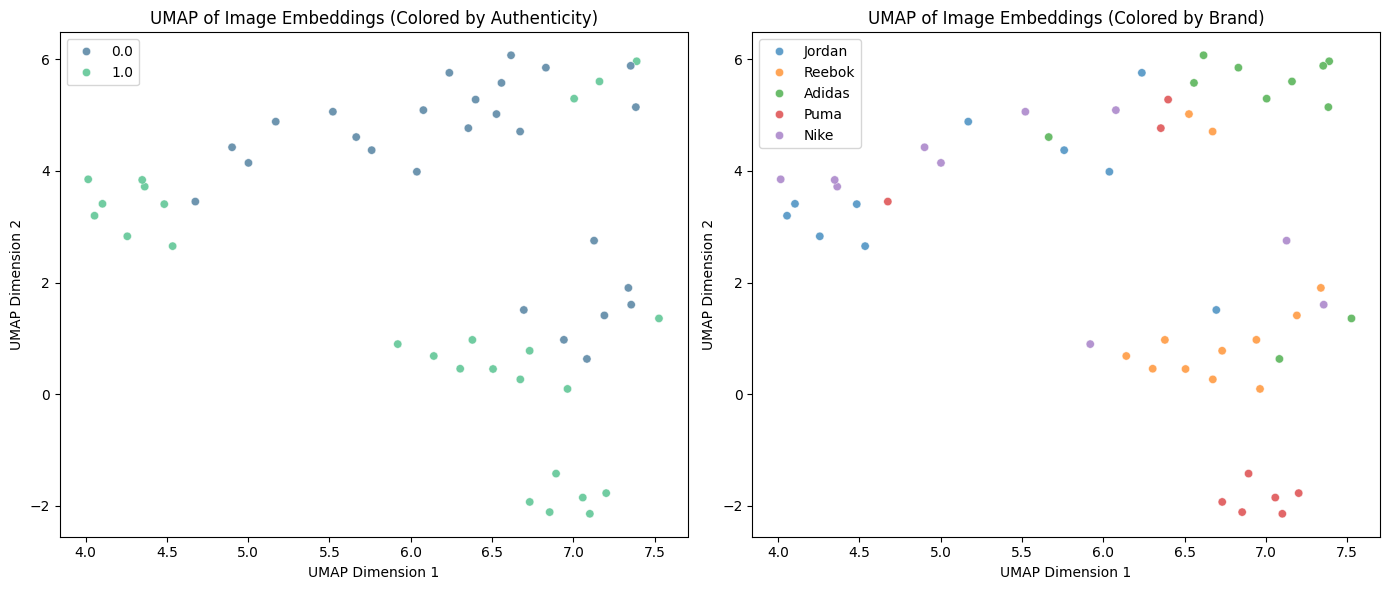

In [ ]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# Function to get embeddings from the model
def get_embeddings(model, dataloader):
    model.eval()
    all_embeddings = []
    all_labels = []
    all_brands = []
    with torch.no_grad():
        for batch in dataloader:
            imgs = batch['image'].to(DEVICE)
            brands = batch['brand'].to(DEVICE)
            prices = batch['price'].to(DEVICE)
            labels = batch.get('label', None)

            # Model returns auth_logits, brand_logits, img_emb, contrast_vec
            _, _, img_emb, _ = model(imgs, brands, prices)
            all_embeddings.append(img_emb.cpu().numpy())
            if labels is not None:
                all_labels.append(labels.cpu().numpy())
            all_brands.append(brands.cpu().numpy())
    return np.concatenate(all_embeddings), np.concatenate(all_labels) if all_labels else None, np.concatenate(all_brands)

# Get embeddings, labels, and brands for the validation set
print("Extracting embeddings for UMAP...")
val_embeddings, val_labels, val_brand_indices = get_embeddings(model, val_loader)
val_brand_names = brand_encoder.inverse_transform(val_brand_indices)

# Apply UMAP
print("Applying UMAP dimensionality reduction...")
reducer = umap.UMAP(n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(val_embeddings)

# Plotting
plt.figure(figsize=(14, 6))

# Plot 1: Colored by Authenticity
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=embedding_2d[:, 0],
    y=embedding_2d[:, 1],
    hue=val_labels,
    palette='viridis',
    legend='full',
    alpha=0.7
)
plt.title('UMAP of Image Embeddings (Colored by Authenticity)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

# Plot 2: Colored by Brand
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=embedding_2d[:, 0],
    y=embedding_2d[:, 1],
    hue=val_brand_names,
    palette='tab10',
    legend='full',
    alpha=0.7
)
plt.title('UMAP of Image Embeddings (Colored by Brand)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

plt.tight_layout()
plt.show()

### Plot 2: Training and Validation Loss & Accuracy Curves
These plots show the progression of loss and accuracy over each training epoch. They are essential for monitoring model performance and detecting issues like overfitting or underfitting.

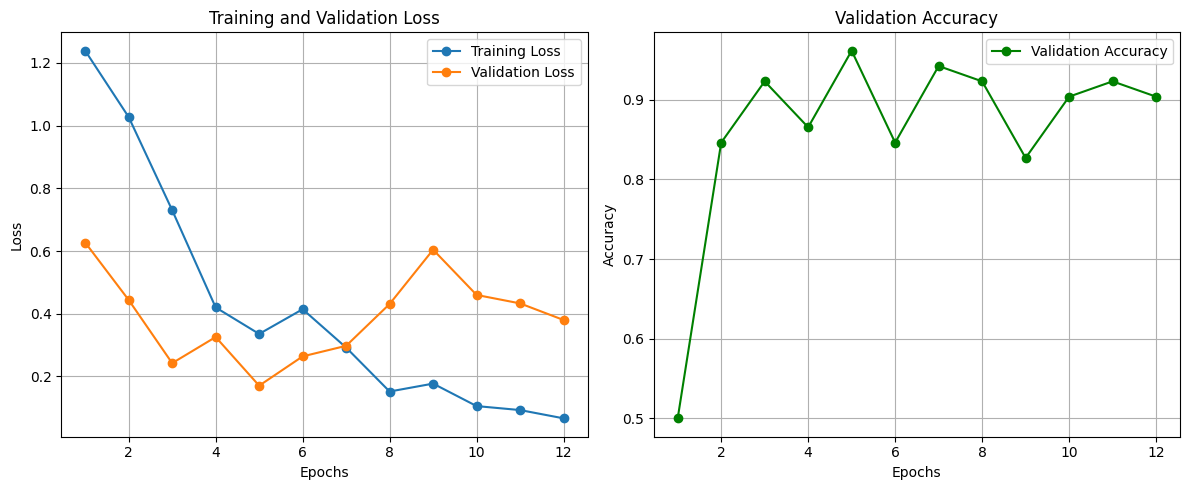

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'o-', label='Training Loss')
plt.plot(epochs, val_losses, 'o-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accs, 'o-', color='green', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Plot 3: Confusion Matrix and ROC Curve (Test Set)
These plots use the predictions from the test set (`results` DataFrame) to provide a detailed view of the classifier's performance.

*   **Confusion Matrix**: Shows the number of correct and incorrect predictions made by the classification model compared to the actual outcomes. It breaks down performance by class.
*   **ROC Curve**: Visualizes the diagnostic ability of a binary classifier system as its discrimination threshold is varied. It plots the True Positive Rate (sensitivity) against the False Positive Rate (1-specificity) at various threshold settings.

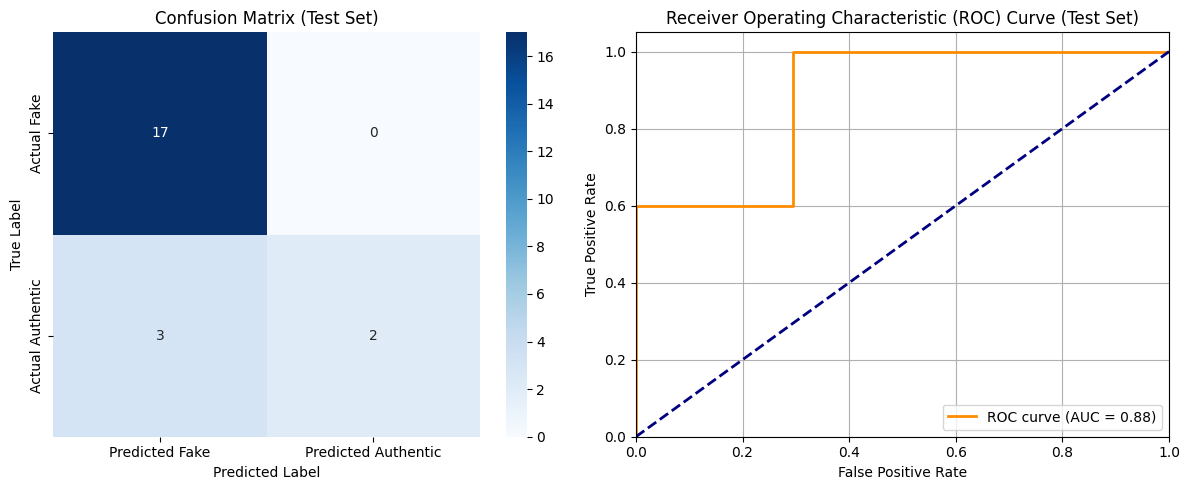

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'results' DataFrame from Cell 13 contains 'Authentic', 'Pred_Label', 'Pred_Prob'
if 'Authentic' in results.columns and 'Pred_Label' in results.columns and 'Pred_Prob' in results.columns:
    y_true_test = results['Authentic'].values
    y_pred_test = results['Pred_Label'].values
    y_pred_prob_test = results['Pred_Prob'].values

    # Confusion Matrix
    cm = confusion_matrix(y_true_test, y_pred_test)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Fake', 'Predicted Authentic'],
                yticklabels=['Actual Fake', 'Actual Authentic'])
    plt.title('Confusion Matrix (Test Set)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_true_test, y_pred_prob_test)
    roc_auc = auc(fpr, tpr)

    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve (Test Set)')
    plt.legend(loc="lower right")
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("Required columns for Confusion Matrix/ROC Curve not found in 'results' DataFrame.")

In [3]:
# from https://gist.github.com/jonathanagustin/b67b97ef12c53a8dec27b343dca4abba
# install can take a minute

import os
# @title Convert Notebook to PDF. Save Notebook to given directory
NOTEBOOKS_DIR = "/content/drive/MyDrive/Colab Notebooks" # @param {type:"string"}
NOTEBOOK_NAME = "Copy of Model_evaluation_train_test.ipynb" # @param {type:"string"}
#------------------------------------------------------------------------------#
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
NOTEBOOK_PATH = f"{NOTEBOOKS_DIR}/{NOTEBOOK_NAME}"
assert os.path.exists(NOTEBOOK_PATH), f"NOTEBOOK NOT FOUND: {NOTEBOOK_PATH}"
!apt install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic > /dev/null 2>&1
!jupyter nbconvert "$NOTEBOOK_PATH" --to pdf > /dev/null 2>&1
NOTEBOOK_PDF = NOTEBOOK_PATH.rsplit('.', 1)[0] + '.pdf'
assert os.path.exists(NOTEBOOK_PDF), f"ERROR MAKING PDF: {NOTEBOOK_PDF}"
print(f"PDF CREATED: {NOTEBOOK_PDF}")

Mounted at /content/drive/
PDF CREATED: /content/drive/MyDrive/Colab Notebooks/Copy of Model_evaluation_train_test.pdf
